In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

In [2]:
data = tifffile.imread('data/registered_full_movie.tif')
movie = (data - data.min(axis=(1, 2), keepdims=True)) / (np.ptp(data, axis=(1,2), keepdims=True))

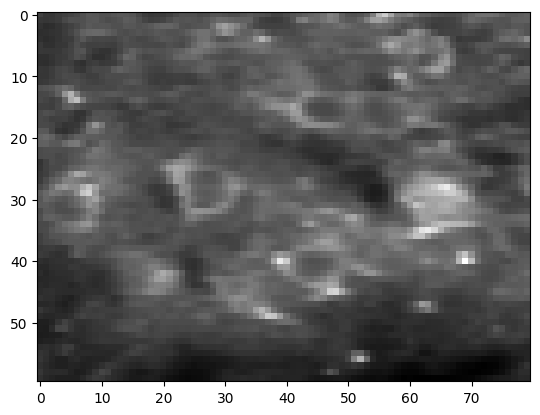

In [3]:
plt.imshow(movie.mean(axis=0), cmap='gray')

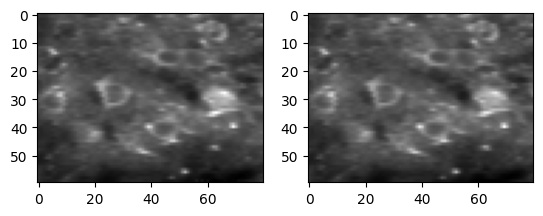

In [ ]:

plt.subplot(121)
plt.imshow(data.mean(axis=0), cmap='gray')

plt.subplot(122)
plt.imshow(movie.mean(axis=0), cmap='gray')

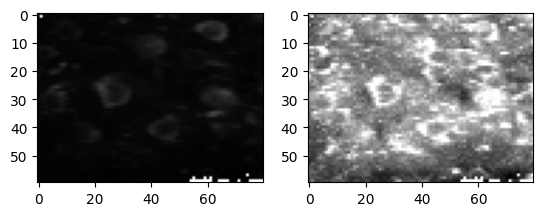

In [4]:

plt.subplot(121)
plt.imshow(data.max(axis=0), cmap='gray')

plt.subplot(122)
plt.imshow(movie.max(axis=0), cmap='gray')

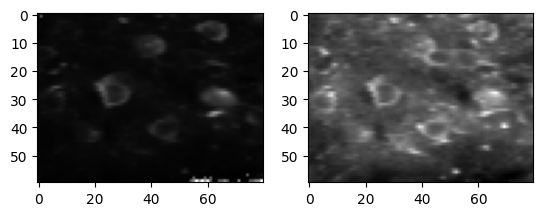

In [5]:

plt.subplot(121)
plt.imshow(data.std(axis=0), cmap='gray')

plt.subplot(122)
plt.imshow(movie.std(axis=0), cmap='gray')

In [6]:
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

In [7]:
smoothed = gaussian(movie.mean(axis=0), sigma=1)
thresh = threshold_otsu(smoothed)
binary = smoothed > thresh

In [8]:
cleaned = remove_small_objects(binary, min_size=30)

In [9]:
label_img = label(cleaned)
rois = [region for region in regionprops(label_img) if region.eccentricity < 0.9]

Manual Labelling with napari

In [10]:
import napari
viewer = napari.Viewer()
viewer.add_image(movie.mean(axis=0), name="Mean Projection", contrast_limits=[0, 1]) 

<Image layer 'Mean Projection' at 0x1d0a8b3bfb0>

INFO: Current selected label is not being used. You will need to use it first to be able to set the current select label to the next one available


In [11]:
labeled_rois = viewer.layers["rois"].data

In [14]:
labeled_rois.astype(np.uint16)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [16]:
label_1_mask = (labeled_rois == 1)

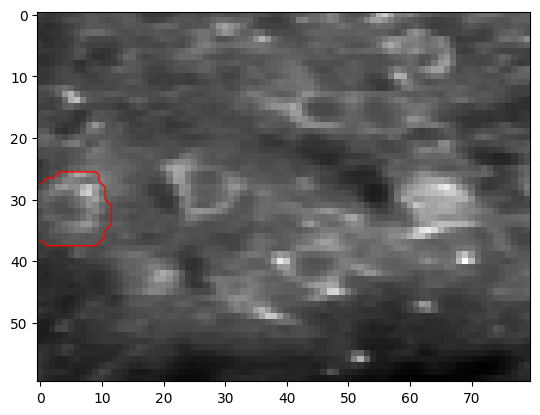

In [17]:
plt.imshow(movie.mean(axis=0), cmap='gray')
plt.contour(label_1_mask, colors='r', linewidths=1)

In [18]:
roi_pixels = label_1_mask.flatten()

In [19]:
T, Y, X = movie.shape
movie_flat = movie.reshape(T, -1)

In [20]:
trace = movie_flat[:, roi_pixels].mean(axis=1)

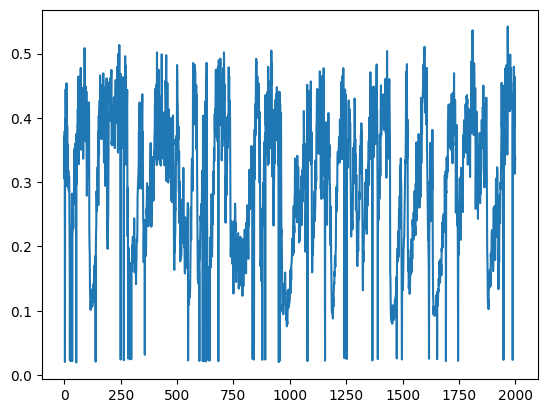

In [21]:
plt.plot(trace)

In [ ]:
roi_pixels = label_1_mask.flatten()

In [23]:
label_1_mask.shape, movie.shape

((60, 80), (2000, 60, 80))

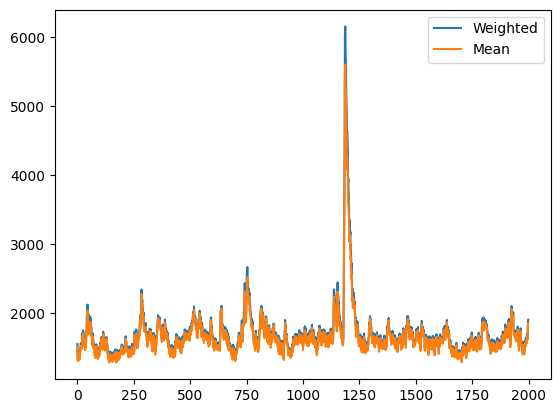

In [32]:
mask = (labeled_rois == 5)
y_coords, x_coords = np.nonzero(mask)
coords = list(zip(x_coords, y_coords))

traces = np.array([data[:, y, x] for (x,y) in coords])

mean_trace = np.mean(traces, axis=0)

active_pixel_means = np.mean(traces, axis=1)
weights = active_pixel_means / np.sum(active_pixel_means)

weighted_trace = np.average(traces, axis=0, weights=weights)
plt.plot(weighted_trace, label='Weighted')
plt.plot(mean_trace, label='Mean')
plt.legend()



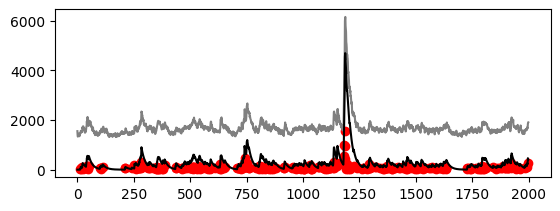

In [34]:
from oasis.functions import deconvolve

denoised_signal, spike_train, _, _, _ = deconvolve(weighted_trace)
spike_indices = np.where(np.round(spike_train) > 0)[0]
spike_amplitudes = spike_train[spike_indices]

plt.subplot(211)
plt.plot(weighted_trace, color='gray')
plt.plot(denoised_signal, color='k')
plt.scatter(np.arange(len(spike_train))[spike_indices], spike_train[spike_indices], color='r')